<a href="https://colab.research.google.com/github/Tomershigani/Decoding-the-Mind/blob/main/Computational_language_and_cognition_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured

## **First task** - HW3 analysis with Word2vec

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip

--2023-06-27 18:54:03--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 142.250.159.138, 142.250.159.100, 142.250.159.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.159.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qos3e6e9ilt5latt6j8kou3gfatppu2r/1687892025000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=bba06216-6360-4dd0-8819-d6c7ff0fec3f [following]
--2023-06-27 18:54:04--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qos3e6e9ilt5latt6j8kou3gfatppu2r/1687892025000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=bba06216-6360-4dd0-8819-d6c7ff0fec3f
Resolving doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs.googleusercontent.com)... 64.233.191.1

In [ ]:
import numpy as np
from learn_decoder import *

data = read_matrix("imaging_data.csv", sep=",")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

We will use word2vec-google-news-300 model to get the new embeddings. We chose word2vec because it's known word embedding method which we learned in class. The number 300 at the end of the model means the embeddings' vectors are with dimention of 300.

In [ ]:
import gensim.downloader as downloader

model = downloader.load('word2vec-google-news-300')

[=================================================-] 99.9% 1660.6/1662.8MB downloaded


In [ ]:
# model2 = downloader.load('fasttext-wiki-news-subwords-300')

The word embeddings' models are trained on certain corpus. Therefore, there could be some words which don't have embeddings. We would like to check if there are any so we will be able to address it appropriately.

In [ ]:
# Check if the model recognize all the words or not.
for i,concept in enumerate(concepts):
    if concept not in model:
      print(f'Concept number {i} is {concept} and unkown to the model')

Concept number 6 is argumentatively and unkown to the model


In [ ]:
'argumentative' in model

True

We have only one out of vucabulary (OOV) word. We decided to represent it's vector with the vector of the word "argumentative". Our decision is based on the intuition that argumentative is similar to the word argumentatively semantically. Due to that, if we want to check connections between argumentative and other words we will expect it to resemble well the connections between argumentatively and these words.

In [ ]:
# We create the vectors matrix to create the decoder
vectors = []

for concept in concepts:
  if concept in model:
    vec = model[concept]
  else:
    vec = model['argumentative']

  vectors.append(vec)

vectors = np.array(vectors)
vectors.shape

(180, 300)

In [ ]:
data.shape

(180, 170712)

In [ ]:
from collections import defaultdict

def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    return np.dot(x, y) / (norm_x * norm_y)

def get_accuracy(true_idx, v, vectors):
  idx_vectors = defaultdict(None)
  for row in range(vectors.shape[0]):
    idx_vectors[row] = cosine_similarity(v, vectors[row, :])
  idx_vectors = dict(sorted(idx_vectors.items(), reverse=True, key=lambda item: item[1]))
  c = 1
  for key in idx_vectors.keys():
    if key == true_idx:
      return  (vectors.shape[0] - c) / vectors.shape[0]
    else:
      c += 1

In [ ]:
start_row = 0
end_row = 10
idx_score = defaultdict(None)
concept_score = []

vectors = []

for concept in concepts:
  if concept in model:
    vec = model[concept]
  else:
    vec = model['argumentative']

  vectors.append(vec)

vectors = np.array(vectors)

for i in range(0,18):
  test_vector_matrix = vectors[start_row:end_row]
  test_data_matrix = data[start_row:end_row]

  test_list = [j for j in range(start_row,end_row)]
  train_list = [i for i in range(180) if i not in test_list]

  m = learn_decoder(data[train_list, :],vectors[train_list, :])
  start_row+=10
  end_row+=10
  prediction = np.dot(test_data_matrix,m)
  score_list = []
  for row , true_index in enumerate(test_list):
    accuracy = get_accuracy(true_index, prediction[row], vectors)
    concept_score.append((concepts[true_index], accuracy))
    score_list.append(accuracy)

  idx_score[i + 1] = np.sum(score_list)/len(score_list)

print(idx_score)

defaultdict(None, {1: 0.695, 2: 0.5566666666666668, 3: 0.5333333333333333, 4: 0.6738888888888889, 5: 0.7666666666666666, 6: 0.7, 7: 0.6722222222222223, 8: 0.663888888888889, 9: 0.6338888888888888, 10: 0.7183333333333334, 11: 0.6538888888888889, 12: 0.655, 13: 0.6416666666666666, 14: 0.6950000000000001, 15: 0.7972222222222223, 16: 0.5927777777777777, 17: 0.6088888888888888, 18: 0.6833333333333333})


In [ ]:
values = list(idx_score.values())
min(values), max(values), sum(values) / len(values)

(0.5333333333333333, 0.7972222222222223, 0.6634259259259259)

In [ ]:
start_row = 0
end_row = 10
idx_score = defaultdict(None)
concept_score = []

vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")

for i in range(0,18):
  test_vector_matrix = vectors[start_row:end_row]
  test_data_matrix = data[start_row:end_row]

  test_list = [j for j in range(start_row,end_row)]
  train_list = [i for i in range(180) if i not in test_list]

  m = learn_decoder(data[train_list, :],vectors[train_list, :])
  start_row+=10
  end_row+=10
  prediction = np.dot(test_data_matrix,m)
  score_list = []
  for row , true_index in enumerate(test_list):
    accuracy = get_accuracy(true_index, prediction[row], vectors)
    concept_score.append((concepts[true_index], accuracy))
    score_list.append(accuracy)

  idx_score[i + 1] = np.sum(score_list)/len(score_list)

print(idx_score)

defaultdict(None, {1: 0.6294444444444445, 2: 0.6538888888888889, 3: 0.6644444444444444, 4: 0.6077777777777779, 5: 0.5483333333333333, 6: 0.586111111111111, 7: 0.5722222222222222, 8: 0.7405555555555556, 9: 0.41611111111111115, 10: 0.7827777777777778, 11: 0.6355555555555555, 12: 0.6861111111111111, 13: 0.795, 14: 0.6333333333333334, 15: 0.7683333333333333, 16: 0.7955555555555556, 17: 0.7794444444444444, 18: 0.513888888888889})


In [ ]:
values = list(idx_score.values())
min(values), max(values), sum(values) / len(values)

(0.41611111111111115, 0.7955555555555556, 0.6560493827160493)

In [ ]:
concept_score.sort(reverse=True, key=lambda x: x[1])
print(sorted(concept_score, key=lambda x: x[1])[:7])
print(concept_score[:7])

[('movie', 0.14444444444444443), ('level', 0.15), ('accomplished', 0.15555555555555556), ('charity', 0.2), ('flow', 0.21666666666666667), ('star', 0.21666666666666667), ('bed', 0.24444444444444444)]
[('laugh', 0.9944444444444445), ('soul', 0.9944444444444445), ('stupid', 0.9944444444444445), ('emotion', 0.9888888888888889), ('hair', 0.9833333333333333), ('silly', 0.9833333333333333), ('dig', 0.9777777777777777)]


In [ ]:
concept_score.sort(reverse=True, key=lambda x: x[1])
print(sorted(concept_score, key=lambda x: x[1])[:7])
print(concept_score[:7])

[('argumentatively', 0.0), ('cockroach', 0.011111111111111112), ('applause', 0.027777777777777776), ('deceive', 0.05), ('electron', 0.06666666666666667), ('dissolve', 0.08888888888888889), ('movie', 0.11666666666666667)]
[('do', 0.9944444444444445), ('food', 0.9944444444444445), ('time', 0.9944444444444445), ('great', 0.9888888888888889), ('laugh', 0.9777777777777777), ('stupid', 0.9722222222222222), ('lady', 0.9666666666666667)]


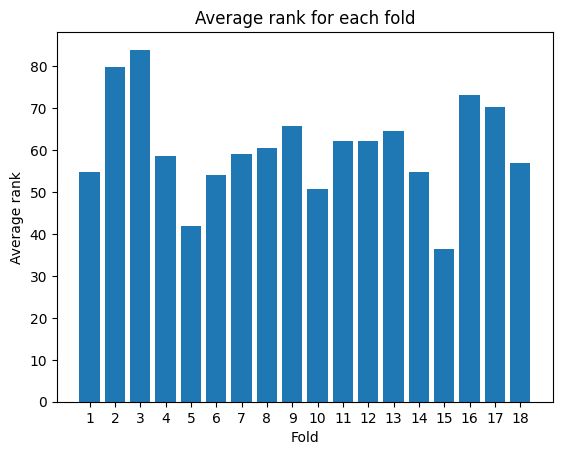

In [ ]:
import matplotlib.pyplot as plt
x_values = list(idx_score.keys())
y_values = list(idx_score.values())

plt.bar(x_values, y_values)
plt.xlabel("Fold")
plt.ylabel("Average rank")
plt.xticks(range(1, 19))
plt.title("Average rank for each fold")
plt.show()

## **Third Task** - train on EXP1 data and test on EXP2 and EXP3

Due to the differences in the csv formats: we tried to use the given read_matrix and we got an error. We explored the data and saw that the new data has columns' labels and index in each row. So we addapted the given function so it could read the new format.

In [ ]:
import numpy as np

def read_EX1():
    lines = []
    flag = True
    with open('drive/MyDrive/project2_files/neuralData_for_EXP1.csv') as f:
        for line in f:
          if not flag:
            lines.append(list(map(float, line.strip().split(',')[1:])))
          else:
            flag = False
            pass
    return np.array(lines)

We import all the data and vectors

In [ ]:
import pickle as pkl

with open('drive/MyDrive/project2_files/EXP2.pkl', 'rb') as f:
	exp2 = pkl.load(f)

with open('drive/MyDrive/project2_files/EXP3.pkl', 'rb') as f:
	exp3 = pkl.load(f)


ex1_data = read_EX1()
ex1_vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")

ex2_data = np.array(exp2['Fmridata'])
ex2_vectors = read_matrix("drive/MyDrive/project2_files/vectors_384sentences.GV42B300.average.txt", sep=" ")

ex3_data = np.array(exp3['Fmridata'])
ex3_vectors = read_matrix("drive/MyDrive/project2_files/vectors_243sentences.GV42B300.average.txt", sep=" ")

In [ ]:
# We learn a decoder based on the EXP1's data
M = learn_decoder(ex1_data, ex1_vectors)

In [ ]:
# Check that the shape is correct
M.shape

(185866, 300)

In [ ]:
ex2_prediction = np.dot(ex2_data,M)
score_list = []
for true_index, row in enumerate(ex2_prediction):
  accuracy = get_accuracy(true_index, row, ex2_vectors)
  score_list.append(accuracy)

sum(score_list) / len(score_list)

0.5913357204861112

In [ ]:
ex3_prediction = np.dot(ex3_data,M)
score_list = []
for true_index, row in enumerate(ex3_prediction):
  accuracy = get_accuracy(true_index, row, ex3_vectors)
  score_list.append(accuracy)

sum(score_list) / len(score_list)

0.585412115361818

להוסיף הסבר או אולי ניתוחים נוספים על התוצאות וכולי
אולי משהו בסגנון של למרות שהדאטא שהוא אומן עליו לא זהה לחולוטין הצלחנו ללמוד מהייצוגים משהו ולכן התוצאות טובות יותר ממסווג רנדומי.

## Forth Task - preform the third task but with relation to the concepts of each sentence.

First, we will check the data's structures so we will be able to extract each sentence's concept successfully.

In [ ]:
exp2['labelsPassageForEachSentence'][0:5], exp2['labelsPassageCategory'][0:5], exp2['keyPassageCategory']

(array([[1],
        [1],
        [1],
        [1],
        [2]], dtype=uint8),
 array([[18],
        [10],
        [12],
        [ 7],
        [23]], dtype=uint8),
 array([[array(['animal'], dtype='<U6'),
         array(['appliance'], dtype='<U9'), array(['bird'], dtype='<U4'),
         array(['body_part'], dtype='<U9'),
         array(['building_part'], dtype='<U13'),
         array(['clothing'], dtype='<U8'), array(['crime'], dtype='<U5'),
         array(['disaster'], dtype='<U8'),
         array(['drink_non_alcoholic'], dtype='<U19'),
         array(['dwelling'], dtype='<U8'), array(['fish'], dtype='<U4'),
         array(['fruit'], dtype='<U5'), array(['furniture'], dtype='<U9'),
         array(['human'], dtype='<U5'), array(['insect'], dtype='<U6'),
         array(['kitchen_utensil'], dtype='<U15'),
         array(['landscape'], dtype='<U9'), array(['music'], dtype='<U5'),
         array(['place'], dtype='<U5'),
         array(['profession'], dtype='<U10'),
         array(['tool']

As we can see, labelsPassageForEachSentence is a list of lists from length of 1. Meaning that in order to extract the passage index of sentence "i" we will have to call labelsPassageForEachSentence[i][0].
The same goes for labelsPassageCategory, in order to extract the category's index of passage "i" we will have to call labelsPassageCategory[i][0].

keyPassageCategory is a list with one element which is the list of lists which contain the concepts. Meaning that in order to extract the category's name of category "i" we will have to call keyPassageCategory[0][i][0].

Now, we will check that the dimentions of each list makes sense.

In [ ]:
len(exp2['labelsPassageForEachSentence']), len(exp2['labelsPassageCategory']), len(exp2['keyPassageCategory'][0])

(384, 96, 24)

In [ ]:
# This function receivest the exp file (EXP2/EXP3) and create a list in which element i is the category of sentence i
def get_sentence_categories(exp):
  sentence_category = []
  passage_sentence = exp['labelsPassageForEachSentence']
  passage_category_index = exp['labelsPassageCategory']
  category_index = exp['keyPassageCategory'][0]
  for i in range(len(passage_sentence)):
    sentence_category.append(category_index[passage_category_index[passage_sentence[i][0] - 1][0]  - 1][0])
  return sentence_category

EXP2

In [ ]:
ex2_prediction = np.dot(ex2_data,M)
passage_category_score = defaultdict(lambda: [])
sentence_category = get_sentence_categories(exp2)
score_list = []
for true_index, row in enumerate(ex2_prediction):
  accuracy = get_accuracy(true_index, row, ex2_vectors)
  passage_category_score[sentence_category[true_index]].append(accuracy)
  score_list.append(accuracy)

sum(score_list) / len(score_list)

0.5913357204861112

In [ ]:
# We create an average accuracy rank per category
for key in passage_category_score.keys():
  if key is None:
    pass
  else:
    scores_list = passage_category_score[key]
    passage_category_score[key] = sum(scores_list) / len(scores_list)

In [ ]:
concepts

array(['ability', 'accomplished', 'angry', 'apartment', 'applause',
       'argument', 'argumentatively', 'art', 'attitude', 'bag', 'ball',
       'bar', 'bear', 'beat', 'bed', 'beer', 'big', 'bird', 'blood',
       'body', 'brain', 'broken', 'building', 'burn', 'business',
       'camera', 'carefully', 'challenge', 'charity', 'charming',
       'clothes', 'cockroach', 'code', 'collection', 'computer',
       'construction', 'cook', 'counting', 'crazy', 'damage', 'dance',
       'dangerous', 'deceive', 'dedication', 'deliberately', 'delivery',
       'dessert', 'device', 'dig', 'dinner', 'disease', 'dissolve',
       'disturb', 'do', 'doctor', 'dog', 'dressing', 'driver', 'economy',
       'election', 'electron', 'elegance', 'emotion', 'emotionally',
       'engine', 'event', 'experiment', 'extremely', 'feeling', 'fight',
       'fish', 'flow', 'food', 'garbage', 'gold', 'great', 'gun', 'hair',
       'help', 'hurting', 'ignorance', 'illness', 'impress', 'invention',
       'investigat

In [ ]:
passage_category_score = dict(sorted(passage_category_score.items(), key=lambda item: item[1]))
passage_category_score

{'profession': 0.3512369791666667,
 'vegetable': 0.3811848958333333,
 'animal': 0.4889322916666667,
 'vehicles_transport': 0.5138346354166667,
 'music': 0.5182291666666666,
 'insect': 0.5315755208333334,
 'landscape': 0.5403645833333333,
 'fruit': 0.5408528645833334,
 'crime': 0.5706380208333333,
 'weapon': 0.5734049479166666,
 'clothing': 0.58251953125,
 'building_part': 0.5869140625,
 'place': 0.58984375,
 'bird': 0.5929361979166666,
 'tool': 0.6013997395833333,
 'fish': 0.6031901041666666,
 'disaster': 0.6111653645833334,
 'kitchen_utensil': 0.6321614583333334,
 'furniture': 0.6565755208333334,
 'appliance': 0.7037760416666667,
 'dwelling': 0.7039388020833334,
 'drink_non_alcoholic': 0.7423502604166667,
 'human': 0.7584635416666665,
 'body_part': 0.8165690104166669}

לחרטט משהו על התצאות כתלות בקטגוריה

EXP3

In [ ]:
ex3_prediction = np.dot(ex3_data,M)
passage_category_score = defaultdict(lambda: [])
sentence_category = get_sentence_categories(exp3)
score_list = []
for true_index, row in enumerate(ex3_prediction):
  accuracy = get_accuracy(true_index, row, ex3_vectors)
  passage_category_score[sentence_category[true_index]].append(accuracy)
  score_list.append(accuracy)

sum(score_list) / len(score_list)

0.585412115361818

In [ ]:
for key in passage_category_score.keys():
  if key is None:
    pass
  else:
    scores_list = passage_category_score[key]
    passage_category_score[key] = sum(scores_list) / len(scores_list)

In [ ]:
passage_category_score = dict(sorted(passage_category_score.items(), key=lambda item: item[1]))
passage_category_score

{'beekeeping': 0.30115974560419007,
 'owl': 0.388477366255144,
 'lawn_mower': 0.39053497942386833,
 'pyramid': 0.394238683127572,
 'pharmacist': 0.4378600823045268,
 'skiing': 0.4670781893004115,
 'ice_cream': 0.5078189300411523,
 'infection': 0.5135802469135802,
 'astronaut': 0.5444444444444445,
 'rock_climbing': 0.5548073325851104,
 'blindness': 0.5683127572016461,
 'tuxedo': 0.5827160493827159,
 'hurricane': 0.5893004115226337,
 'computer_graphics': 0.631687242798354,
 'polar_bear': 0.6637860082304528,
 'painter': 0.6670781893004115,
 'taste': 0.6762688614540466,
 'gambling': 0.705349794238683,
 'law_school': 0.7193415637860083,
 'bone_fracture': 0.7197904975682753,
 'opera': 0.7381219603441825,
 'castle': 0.7567901234567901,
 'stress': 0.7604938271604939,
 'dreams': 0.7827160493827161}

# Semi Structured

## **First Task** - Decoder from contextual word embeddings

After googling "huggingface sentence embeddings" we got into huggingface's site in which we were taught how to use BERT to create an embedding for a sentence. We will install the library and create new embeddings.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip
!pip install sentence-transformers

--2023-07-01 07:57:03--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 74.125.141.102, 74.125.141.139, 74.125.141.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.141.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p9n7mu61i8hd662njlulbs23ejfgdb07/1688198175000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=a03b1a30-03fc-43e1-9a77-afa8b4b4cdd2 [following]
--2023-07-01 07:57:03--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p9n7mu61i8hd662njlulbs23ejfgdb07/1688198175000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=a03b1a30-03fc-43e1-9a77-afa8b4b4cdd2
Resolving doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs.googleusercontent.com)... 108.177.11.132, 

In [ ]:
from sentence_transformers import SentenceTransformer

From searching in the internet we encountered a BERT based model which consumes sentences and yields their embeddings. We will use it.

In [ ]:
model_name = 'all-mpnet-base-v2'

model = SentenceTransformer(model_name)

# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm

def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    return np.dot(x, y) / (norm_x * norm_y)

def get_accuracy(true_idx, v, vectors):
  idx_vectors = defaultdict(None)
  for row in range(vectors.shape[0]):
    idx_vectors[row] = cosine_similarity(v, vectors[row, :])
  idx_vectors = dict(sorted(idx_vectors.items(), reverse=True, key=lambda item: item[1]))
  c = 1
  for key in idx_vectors.keys():
    if key == true_idx:
      return  (vectors.shape[0] - c) / vectors.shape[0]
    else:
      c += 1

In [ ]:
from learn_decoder import *
import pickle as pkl
import numpy as np

def read_EX1():
    lines = []
    flag = True
    with open('drive/MyDrive/project2_files/neuralData_for_EXP1.csv') as f:
        for line in f:
          if not flag:
            lines.append(list(map(float, line.strip().split(',')[1:])))
          else:
            flag = False
            pass
    return np.array(lines)

with open('drive/MyDrive/project2_files/EXP2.pkl', 'rb') as f:
	exp2 = pkl.load(f)

with open('drive/MyDrive/project2_files/EXP3.pkl', 'rb') as f:
	exp3 = pkl.load(f)


ex1_data = read_EX1()
ex1_vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")

ex2_data = np.array(exp2['Fmridata'])
ex2_vectors = read_matrix("drive/MyDrive/project2_files/vectors_384sentences.GV42B300.average.txt", sep=" ")

ex3_data = np.array(exp3['Fmridata'])
ex3_vectors = read_matrix("drive/MyDrive/project2_files/vectors_243sentences.GV42B300.average.txt", sep=" ")

In [ ]:
def get_exp_sentences(exp):
  sentences_exp = exp['keySentences']
  sentences = []
  for i in tqdm(range(len(sentences_exp))):
    sentences.append(sentences_exp[i][0][0])
  print(len(sentences))
  return sentences

In [ ]:
exp2_sentences = get_exp_sentences(exp2)
exp3_sentences = get_exp_sentences(exp3)

100%|██████████| 384/384 [00:00<00:00, 267232.91it/s]


384


100%|██████████| 243/243 [00:00<00:00, 602373.45it/s]

243


In [ ]:
def get_embeddings(model, sentences):
  embeddings = []
  for sentence in tqdm(sentences):
    embedding = model.encode(sentence)
    embeddings.append(embedding)
  embeddings = np.array(embeddings)
  return embeddings

In [ ]:
exp2_embeddings = get_embeddings(model, exp2_sentences)
exp3_embeddings = get_embeddings(model, exp3_sentences)
exp2_embeddings.shape, exp3_embeddings.shape

100%|██████████| 243/243 [00:32<00:00,  7.46it/s]


((384, 768), (243, 768))

EXP2 as train

In [ ]:
exp2_decoder = learn_decoder(ex2_data, ex2_vectors)

In [ ]:
test = learn_decoder(ex2_vectors, ex2_data)
test.shape

(300, 185866)

In [ ]:
exp2_decoder.shape

(185866, 300)

In [ ]:
ex3_prediction = np.dot(ex3_data, exp2_decoder)
score_list = []
for true_index, row in tqdm(enumerate(ex3_prediction)):
  accuracy = get_accuracy(true_index, row, ex3_vectors)
  score_list.append(accuracy)

max(score_list), min(score_list ),sum(score_list) / len(score_list)

243it [00:00, 282.66it/s]


(0.9958847736625515, 0.0, 0.6115260207624175)

In [ ]:
exp2_decoder_embed = learn_decoder(ex2_data, exp2_embeddings)

In [ ]:
ex3_prediction = np.dot(ex3_data, exp2_decoder_embed)
score_list = []
for true_index, row in tqdm(enumerate(ex3_prediction)):
  accuracy = get_accuracy(true_index, row, exp3_embeddings)
  score_list.append(accuracy)

max(score_list), min(score_list ),sum(score_list) / len(score_list)

243it [00:01, 140.40it/s]


(0.9958847736625515, 0.00411522633744856, 0.6727294281020847)

EXP3 as train

In [ ]:
exp3_decoder = learn_decoder(ex3_data, ex3_vectors)

In [ ]:
ex2_prediction = np.dot(ex2_data, exp3_decoder)
score_list = []
for true_index, row in tqdm(enumerate(ex2_prediction)):
  accuracy = get_accuracy(true_index, row, ex2_vectors)
  score_list.append(accuracy)

max(score_list), min(score_list ),sum(score_list) / len(score_list)

384it [00:02, 179.28it/s]


(0.9973958333333334, 0.0, 0.6046549479166666)

In [ ]:
exp3_decoder_embed = learn_decoder(ex3_data, exp3_embeddings)

In [ ]:
ex2_prediction = np.dot(ex2_data, exp3_decoder_embed)
score_list = []
for true_index, row in tqdm(enumerate(ex2_prediction)):
  accuracy = get_accuracy(true_index, row, exp2_embeddings)
  score_list.append(accuracy)

max(score_list), min(score_list ),sum(score_list) / len(score_list)

384it [00:04, 94.64it/s]


(0.9973958333333334, 0.005208333333333333, 0.6784057617187501)

## **Second Task** - Brain Encoder

In [ ]:
!pip install plotly

In [ ]:
import pandas as pd
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

def redisual_analysis(X, y, y_hat, print_table = False):
    # Calculates residuals analysis and prints the table if requested
    n = X.shape[0]
    p = X.shape[1]

    y_bar = np.mean(y)
    SSR = np.linalg.norm(y_hat - y_bar) ** 2
    SSRes = np.linalg.norm(y - y_hat) ** 2
    SST = SSR + SSRes

    MSR = SSR / (p - 1)
    MSRes = SSRes / (n - p)
    MST = SST / (n - 1)

    f_test = MSR / MSRes
    f_p_value = 1 - stats.f.cdf(f_test, p -1, n- p)

    if print_table:
        residual_values = [(SSR, p - 1, MSR, f_test, f_p_value),
                           (SSRes, n - p, MSRes, None, None),
                           (SST, n - 1, MST, None, None)]
        residual_table = pd.DataFrame(residual_values, columns=['Sum Of Squares', 'df', 'MS', 'F Value', 'F P-Value'],
                                      index=['Regression', 'Residuals', 'Total'])
        print(residual_table)

    return SSR, SSRes, SST, MSR, MSRes, MST, f_test, f_p_value

def calc_R_2(SSR, SST):
    return SSR / SST


def get_inv_XT_X(X):
    XT_X = np.matmul(X.T, X)
    return np.linalg.inv(XT_X)

In [ ]:
X_matrix = ex2_vectors
X_matrix.shape

(384, 300)

In [ ]:
from tqdm import tqdm

voxel_number = list(range(ex2_data.shape[1]))
voxel_dict = {'R2': [], 'pval': []}

X = X_matrix
bias_column = np.ones((X.shape[0], 1))
X = np.hstack((bias_column, X))
inv_XT_X = get_inv_XT_X(X)
P = np.matmul(inv_XT_X, X.T)

for voxel in tqdm(voxel_number):
  y = ex2_data[:, voxel]
  beta_LS = np.matmul(P, y)
  y_hat = np.matmul(X, beta_LS)
  SSR, SSRes, SST, MSR, MSRes, MST, f_test, f_p_value = redisual_analysis(X, y, y_hat)
  R2 = calc_R_2(SSR, SST)
  voxel_dict['R2'].append(R2)
  voxel_dict['pval'].append(f_p_value)

 91%|█████████ | 169586/185866 [02:52<00:21, 774.99it/s]<ipython-input-21-c302df440bbd>:20: RuntimeWarning: invalid value encountered in double_scalars
  f_test = MSR / MSRes
<ipython-input-21-c302df440bbd>:34: RuntimeWarning: invalid value encountered in double_scalars
  return SSR / SST
100%|██████████| 185866/185866 [03:03<00:00, 1014.10it/s]


In [ ]:
df = pd.DataFrame(voxel_dict)
px.histogram(df, x='R2')

In [ ]:
df[df['pval'] < 0.05].count()

R2      29703
pval    29703
dtype: int64

In [ ]:
df[df['pval'] < 0.05].describe(),

(                 R2          pval
 count  29703.000000  2.970300e+04
 mean       0.843027  2.221568e-02
 std        0.010411  1.461784e-02
 min        0.830410  1.098073e-07
 25%        0.834935  9.211395e-03
 50%        0.840525  2.085151e-02
 75%        0.848546  3.449849e-02
 max        0.908849  4.999659e-02,)

In [ ]:
exp2_embeddings.shape

(384, 768)

In [ ]:
voxel_number = list(range(ex2_data.shape[1]))
voxel_dict2 = {'R2': [], 'pval': [], 'ftest': []}

X = exp2_embeddings
bias_column = np.ones((X.shape[0], 1))
X = np.hstack((bias_column, X))
inv_XT_X = get_inv_XT_X(X)
P = np.matmul(inv_XT_X, X.T)

for voxel in tqdm(voxel_number):
  y = ex2_data[:, voxel]
  beta_LS = np.matmul(P, y)
  y_hat = np.matmul(X, beta_LS)
  SSR, _, SST, _, _, _, ftest, f_p_value = redisual_analysis(X, y, y_hat)
  R2 = calc_R_2(SSR, SST)
  voxel_dict2['R2'].append(R2)
  voxel_dict2['pval'].append(f_p_value)
  voxel_dict2['ftest'].append(f_test)

 91%|█████████ | 169503/185866 [03:22<00:08, 1903.07it/s]<ipython-input-21-c302df440bbd>:20: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-21-c302df440bbd>:34: RuntimeWarning:

invalid value encountered in double_scalars

100%|██████████| 185866/185866 [03:33<00:00, 872.10it/s] 


In [ ]:
df2 = pd.DataFrame(voxel_dict2)
px.histogram(df2, x='R2')

In [ ]:
df2[df2['pval'] < 0.05].count()

R2       0
pval     0
ftest    0
dtype: int64

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
ex2_pca_embedding = pca.fit_transform(exp2_embeddings)

In [ ]:
voxel_number = list(range(ex2_data.shape[1]))
voxel_dict3 = {'R2': [], 'pval': [], 'ftest': []}

X = ex2_pca_embedding
bias_column = np.ones((X.shape[0], 1))
X = np.hstack((bias_column, X))
inv_XT_X = get_inv_XT_X(X)
P = np.matmul(inv_XT_X, X.T)

for voxel in tqdm(voxel_number):
  y = ex2_data[:, voxel]
  beta_LS = np.matmul(P, y)
  y_hat = np.matmul(X, beta_LS)
  SSR, _, SST, _, _, _, ftest, f_p_value = redisual_analysis(X, y, y_hat)
  R2 = calc_R_2(SSR, SST)
  voxel_dict3['R2'].append(R2)
  voxel_dict3['pval'].append(f_p_value)
  voxel_dict3['ftest'].append(f_test)

 91%|█████████▏| 169618/185866 [01:59<00:15, 1018.72it/s]<ipython-input-21-c302df440bbd>:20: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-21-c302df440bbd>:34: RuntimeWarning:

invalid value encountered in double_scalars

100%|██████████| 185866/185866 [02:09<00:00, 1434.56it/s]


In [ ]:
df3 = pd.DataFrame(voxel_dict3)
px.histogram(df2, x='R2')

In [ ]:
df3[df3['pval'] < 0.05].count()

R2       78766
pval     78766
ftest    78766
dtype: int64

In [ ]:
df3[df3['pval'] < 0.05].describe()

R2          pval        ftest
count  78766.000000  7.876600e+04  78766.00000
mean       0.848878  1.621014e-02      1.06573
std        0.013786  1.455293e-02      0.00000
min        0.830409  9.119123e-10      1.06573
25%        0.837791  3.298865e-03      1.06573
50%        0.846172  1.187390e-02      1.06573
75%        0.857260  2.684569e-02      1.06573
max        0.923019  4.999987e-02      1.06573

In [ ]:
total=0
r=0.05
I=0.05
for i in range(1,11):
  total+= (100000*(1.05+I)**i - 52000*(1+I)**i)/(1+r)**i

total

783132.3195589697

# Open Part

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip

--2023-07-01 13:07:52--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 173.194.216.139, 173.194.216.100, 173.194.216.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7e5ra3obkoaisnpvn0doa5ahcqfed6dl/1688216850000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=9fb70dd1-9df1-4285-8c6f-c890f2aa25b5 [following]
--2023-07-01 13:07:52--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7e5ra3obkoaisnpvn0doa5ahcqfed6dl/1688216850000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=9fb70dd1-9df1-4285-8c6f-c890f2aa25b5
Resolving doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs.googleusercontent.com)... 173.194.213.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import pickle as pkl
import matplotlib.pyplot as plt
from learn_decoder import *
import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In the open part we chose to focus and explore the similarities of concepts in each space (GloVe embeddings, Word2Vec, Neural vectors etc).

In [ ]:
def read_EX1():
    lines = []
    flag = True
    with open('drive/MyDrive/project2_files/neuralData_for_EXP1.csv') as f:
        for line in f:
          if not flag:
            lines.append(list(map(float, line.strip().split(',')[1:])))
          else:
            flag = False
            pass
    return np.array(lines)


with open('drive/MyDrive/project2_files/EXP2.pkl', 'rb') as f:
	exp2 = pkl.load(f)

with open('drive/MyDrive/project2_files/EXP3.pkl', 'rb') as f:
	exp3 = pkl.load(f)


ex1_data = read_EX1()
ex1_vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")

ex2_data = np.array(exp2['Fmridata'])
ex2_vectors = read_matrix("drive/MyDrive/project2_files/vectors_384sentences.GV42B300.average.txt", sep=" ")

ex3_data = np.array(exp3['Fmridata'])
ex3_vectors = read_matrix("drive/MyDrive/project2_files/vectors_243sentences.GV42B300.average.txt", sep=" ")

## Check for Supervised Clusters

### KNN on the 3 sets without train-test seperation

In [ ]:
from scipy import stats
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def redisual_analysis(X, y, y_hat, print_table = False):
    # Calculates residuals analysis and prints the table if requested
    n = X.shape[0]
    p = X.shape[1]

    y_bar = np.mean(y)
    SSR = np.linalg.norm(y_hat - y_bar) ** 2
    SSRes = np.linalg.norm(y - y_hat) ** 2
    SST = SSR + SSRes

    MSR = SSR / (p - 1)
    MSRes = SSRes / (n - p)
    MST = SST / (n - 1)

    f_test = MSR / MSRes
    f_p_value = 1 - stats.f.cdf(f_test, p -1, n- p)

    if print_table:
        residual_values = [(SSR, p - 1, MSR, f_test, f_p_value),
                           (SSRes, n - p, MSRes, None, None),
                           (SST, n - 1, MST, None, None)]
        residual_table = pd.DataFrame(residual_values, columns=['Sum Of Squares', 'df', 'MS', 'F Value', 'F P-Value'],
                                      index=['Regression', 'Residuals', 'Total'])
        print(residual_table)

    return SSR, SSRes, SST, MSR, MSRes, MST, f_test, f_p_value

def calc_R_2(SSR, SST):
    return SSR / SST


def get_inv_XT_X(X):
    XT_X = np.matmul(X.T, X)
    return np.linalg.inv(XT_X)

In [ ]:
voxel_number = list(range(ex2_data.shape[1]))
voxel_list = []

X = ex2_vectors
bias_column = np.ones((X.shape[0], 1))
X = np.hstack((bias_column, X))
inv_XT_X = get_inv_XT_X(X)
P = np.matmul(inv_XT_X, X.T)

for voxel in tqdm(voxel_number):
  y = ex2_data[:, voxel]
  beta_LS = np.matmul(P, y)
  y_hat = np.matmul(X, beta_LS)
  SSR, SSRes, SST, MSR, MSRes, MST, f_test, f_p_value = redisual_analysis(X, y, y_hat)
  R2 = calc_R_2(SSR, SST)
  voxel_list.append((voxel, R2, f_p_value))

 91%|█████████ | 169589/185866 [01:50<00:07, 2107.00it/s]<ipython-input-1-31c00ec9c0c1>:20: RuntimeWarning: invalid value encountered in double_scalars
  f_test = MSR / MSRes
<ipython-input-1-31c00ec9c0c1>:34: RuntimeWarning: invalid value encountered in double_scalars
  return SSR / SST
100%|██████████| 185866/185866 [02:01<00:00, 1530.18it/s]


In [ ]:
voxel_list.sort(key=lambda a: a[2])
s = 5000
top_segnificant = [voxel_list[i][0] for i in range(s)]
segnificant_voxels = ex2_data[:, top_segnificant]

In [ ]:
# This function receivest the exp file (EXP2/EXP3) and create a list in which element i is the category of sentence i
def get_sentence_categories(exp):
  sentence_category = []
  passage_sentence = exp['labelsPassageForEachSentence']
  passage_category_index = exp['labelsPassageCategory']
  category_index = exp['keyPassageCategory'][0]
  for i in range(len(passage_sentence)):
    sentence_category.append(category_index[passage_category_index[passage_sentence[i][0] - 1][0]  - 1][0])
  return sentence_category

In [ ]:
from sklearn import preprocessing

exp2_labels = get_sentence_categories(exp2)
le = preprocessing.LabelEncoder()
le.fit(exp2_labels)
y = le.transform(exp2_labels)

In [ ]:
X = ex2_data
for k in range(2,11):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X, y)
  predictions = knn.predict(X)
  print(k, accuracy_score(predictions, y))

2 0.625
3 0.5651041666666666
4 0.5494791666666666
5 0.515625
6 0.5182291666666666
7 0.5026041666666666
8 0.4713541666666667
9 0.4322916666666667
10 0.4296875


In [ ]:
X = segnificant_voxels
for k in range(2,11):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X, y)
  predictions = knn.predict(X)
  print(k, accuracy_score(predictions, y))

2 0.6588541666666666
3 0.5859375
4 0.5859375
5 0.5833333333333334
6 0.5390625
7 0.53125
8 0.4921875
9 0.4739583333333333
10 0.4713541666666667


In [ ]:
X = ex2_vectors
for k in range(2,11):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X, y)
  predictions = knn.predict(X)
  print(k, accuracy_score(predictions, y))

2 0.8229166666666666
3 0.8333333333333334
4 0.8333333333333334
5 0.8333333333333334
6 0.8307291666666666
7 0.8151041666666666
8 0.8203125
9 0.8177083333333334
10 0.7916666666666666


### KNN on the 3 sets using train-test-split

In [ ]:
from sklearn.model_selection import train_test_split

def stacking(X):
  final = X[0]
  for i in range(1, len(X)):
    final = np.concatenate((final, X[i]), axis=0)
  return final

def train_test_seperation(data, labels):
  df = pd.DataFrame(data)
  df['labels'] = labels
  concepts = list(set(labels))
  X_train, X_test, y_train, y_test = [], [], [], []
  for concept in concepts:
    relevant = df[df['labels'] == concept]
    train, test = train_test_split(relevant, test_size=0.3, random_state=3)
    X_train.append(train.loc[:, train.columns != 'labels'].to_numpy())
    y_train.append(train['labels'].to_numpy())
    X_test.append(test.loc[:, test.columns != 'labels'].to_numpy())
    y_test.append(test['labels'].to_numpy())

  X_train = stacking(X_train)
  X_test = stacking(X_test)
  y_train = stacking(y_train)
  y_test = stacking(y_test)
  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_seperation(ex2_data, exp2_labels)
for k in range(2,11):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  predictions = knn.predict(X_test)
  print(k, accuracy_score(predictions, y_test))

2 0.10833333333333334
3 0.10833333333333334
4 0.10833333333333334
5 0.11666666666666667
6 0.10833333333333334
7 0.15
8 0.15833333333333333
9 0.15
10 0.13333333333333333


In [ ]:
X_train, X_test, y_train, y_test = train_test_seperation(ex2_vectors, exp2_labels)
for k in range(2,11):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  predictions = knn.predict(X_test)
  print(k, accuracy_score(predictions, y_test))

2 0.625
3 0.6
4 0.625
5 0.6416666666666667
6 0.7083333333333334
7 0.7
8 0.6916666666666667
9 0.625
10 0.65


In [ ]:
X_train, X_test, y_train, y_test = train_test_seperation(segnificant_voxels, exp2_labels)
for k in range(2,11):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  predictions = knn.predict(X_test)
  print(k, accuracy_score(predictions, y_test))

2 0.16666666666666666
3 0.16666666666666666
4 0.15833333333333333
5 0.15
6 0.15833333333333333
7 0.16666666666666666
8 0.19166666666666668
9 0.175
10 0.14166666666666666


### Cosine Similarity Analysis

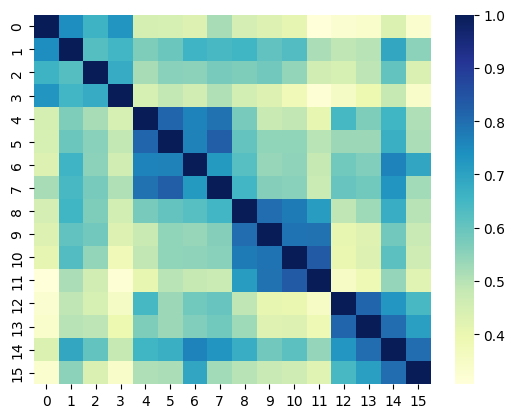

['music',
 'music',
 'music',
 'music',
 'dwelling',
 'dwelling',
 'dwelling',
 'dwelling',
 'fruit',
 'fruit',
 'fruit',
 'fruit',
 'crime',
 'crime',
 'crime',
 'crime']

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt


cosine_matrix = cosine_similarity(ex2_vectors)
sns.heatmap(cosine_matrix[:16,:16], annot=False, cmap="YlGnBu")
plt.show()
exp2_labels[:16]

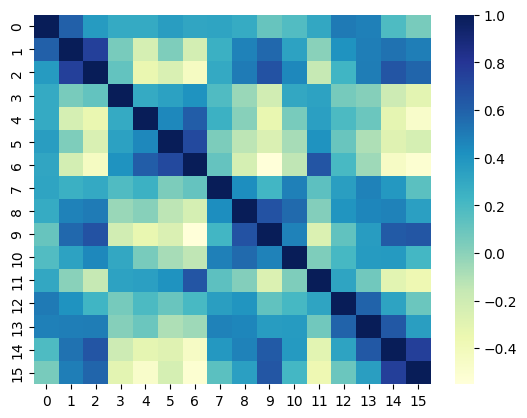

['music',
 'music',
 'music',
 'music',
 'dwelling',
 'dwelling',
 'dwelling',
 'dwelling',
 'fruit',
 'fruit',
 'fruit',
 'fruit']

In [ ]:
cosine_matrix = cosine_similarity(ex2_data)
sns.heatmap(cosine_matrix[:16,:16], annot=False, cmap="YlGnBu")
plt.show()
exp2_labels[:12]

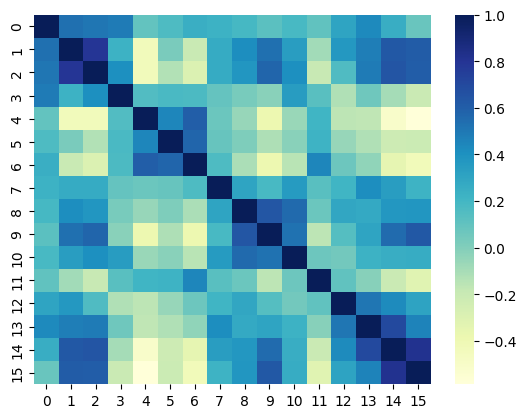

In [ ]:
cosine_matrix = cosine_similarity(segnificant_voxels)
sns.heatmap(cosine_matrix[:16,:16], annot=False, cmap="YlGnBu")
plt.show()

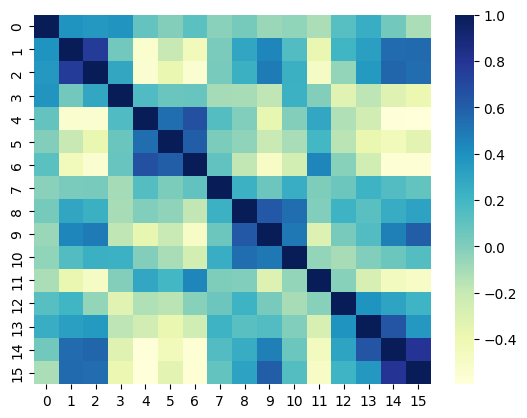

In [ ]:
pca = PCA(n_components=200)

segnificant_voxels_pca = pca.fit_transform(segnificant_voxels)

cosine_matrix = cosine_similarity(segnificant_voxels_pca)
sns.heatmap(cosine_matrix[:16,:16], annot=False, cmap="YlGnBu")
plt.show()

## Cluster on EX1 data

In [ ]:
ex1_vectors.shape

(180, 300)

In [ ]:
ex1_data = pd.read_csv('drive/MyDrive/project2_files/neuralData_for_EXP1.csv', index_col=0)

In [ ]:
ex1_vectors_df = pd.DataFrame(data=ex1_vectors)
ex1_vectors_df

In [ ]:
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts
concepts_df = pd.DataFrame(data=concepts, columns=['concept'])

In [ ]:
n = 1
pca = PCA(n_components=n)

principalComponents = pca.fit_transform(ex1_vectors_df)

ex1_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component ' + str(i + 1) for i in range(n)])
# ex1_pca['concept'] = concepts
ex1_pca

principal component 1
0                 0.720072
1                 1.092098
2                 1.725788
3                -1.620213
4                 1.363782
..                     ...
175               1.876954
176              -0.751253
177              -1.250525
178               2.652490
179               0.579415

[180 rows x 1 columns]

In [ ]:
from sklearn.cluster import KMeans
scores = []
for i in range(2,180):
  kmeans = KMeans(n_clusters=i, n_init="auto").fit(ex1_pca)
  labels = kmeans.predict(ex1_pca)
  centroids  = kmeans.cluster_centers_
  scores.append(sklearn.metrics.silhouette_score(ex1_pca, kmeans.labels_))
scores.index(max(scores)), max(scores)

(0, 0.6250916937746945)

In [ ]:
ex3_df = pd.DataFrame(data=ex3_vectors)
concepts = pd.DataFrame(ex3_concepts)

In [ ]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(ex3_df)

ex3_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
ex3_pca['concept'] = concepts
ex3_pca

principal component 1  principal component 2     concept
0                -0.484128               0.346071  beekeeping
1                -0.215659               0.946568  beekeeping
2                -0.383948               0.458871  beekeeping
3                -0.147205               1.392337  beekeeping
4                 0.080571               0.023881  beekeeping
..                     ...                    ...         ...
238               0.369139               0.298259      skiing
239              -0.004506               0.581612      skiing
240               0.707415              -0.217636      skiing
241               0.432067               0.641465      skiing
242              -0.055482               1.021101      skiing

[243 rows x 3 columns]

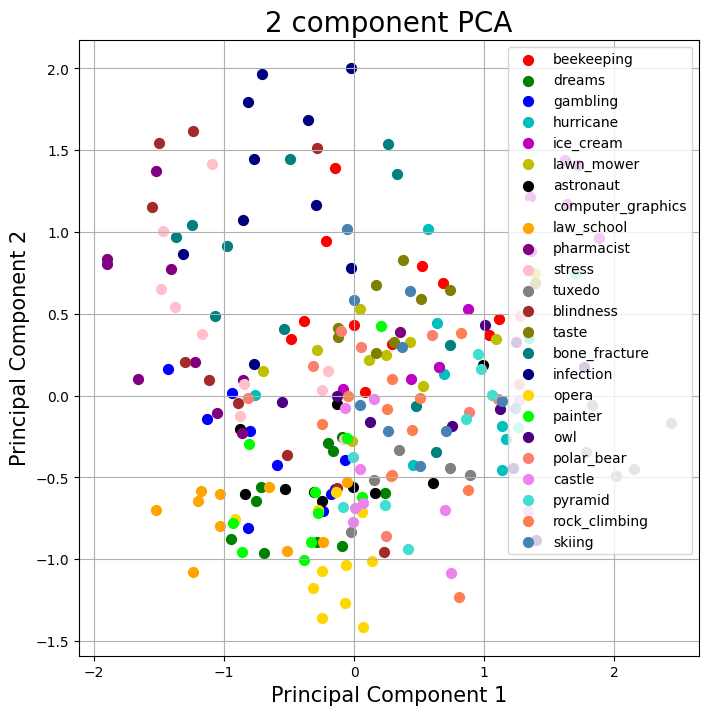

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = concepts[0].unique()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple', 'pink', 'gray', 'brown', 'olive', 'teal', 'navy', 'gold', 'lime', 'indigo', 'salmon', 'violet', 'turquoise', 'coral', 'steelblue']
for target, color in zip(targets,colors):
    indicesToKeep = ex3_pca['concept'] == target
    ax.scatter(ex3_pca.loc[indicesToKeep, 'principal component 1']
               , ex3_pca.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## PCA on categories

In [ ]:
principalDf['concept'] = concepts_df

In [ ]:
def get_sentence_categories(exp):
  sentence_category = []
  passage_sentence = exp['labelsPassageForEachSentence']
  passage_category_index = exp['labelsPassageCategory']
  category_index = exp['keyPassageCategory'][0]
  for i in range(len(passage_sentence)):
    sentence_category.append(category_index[passage_category_index[passage_sentence[i][0] - 1][0]  - 1][0])
  return sentence_category

ex2_concepts = get_sentence_categories(exp2)

In [ ]:
concepts = pd.DataFrame(ex2_concepts)
len(concepts[0].unique())

24

In [ ]:
ex2_df = pd.DataFrame(data=ex2_data)

In [ ]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(ex2_df)

ex2_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
ex2_pca['concept'] = concepts
ex2_pca

principal component 1  principal component 2        concept
0               -40.989876             146.366309          music
1              1621.198981            -347.741747          music
2              2379.013450           -1159.511008          music
3             -1159.247225           -1066.624659          music
4             -1342.272073             105.938563       dwelling
..                     ...                    ...            ...
379            -472.663211             528.138923  building_part
380             164.096467            -266.363911          human
381             275.941075            -485.255243          human
382            -395.220526            -314.445135          human
383             989.299840             703.232497          human

[384 rows x 3 columns]

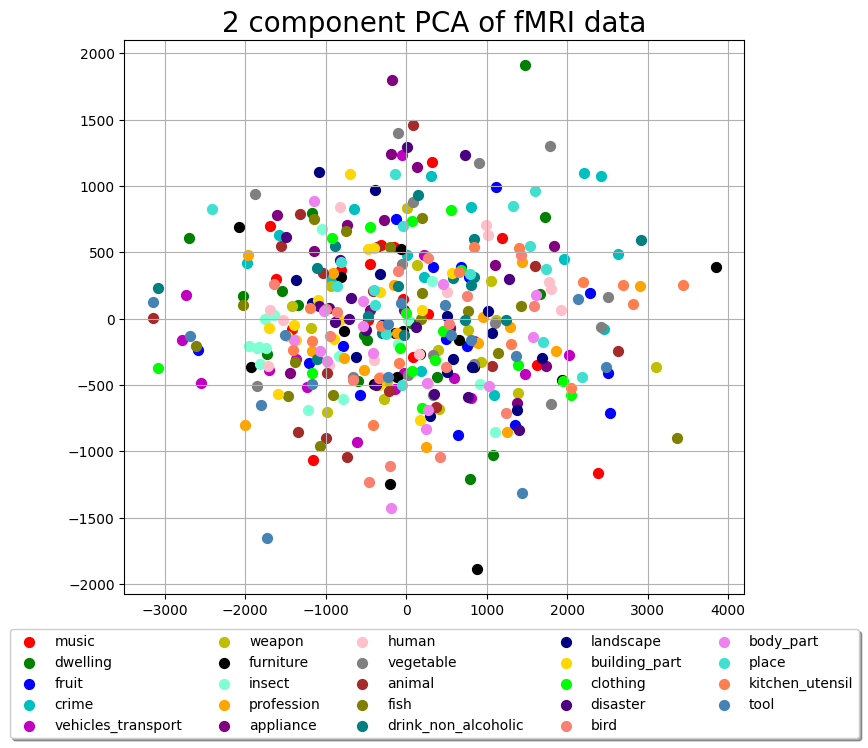

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 component PCA of fMRI data', fontsize = 20)
targets = concepts[0].unique()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'aquamarine','orange', 'purple', 'pink', 'gray', 'brown', 'olive', 'teal', 'navy', 'gold', 'lime', 'indigo', 'salmon', 'violet', 'turquoise', 'coral', 'steelblue']
for target, color in zip(targets,colors):
    indicesToKeep = ex2_pca['concept'] == target
    ax.scatter(ex2_pca.loc[indicesToKeep, 'principal component 1']
               , ex2_pca.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(targets ,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.grid()
plt.show()


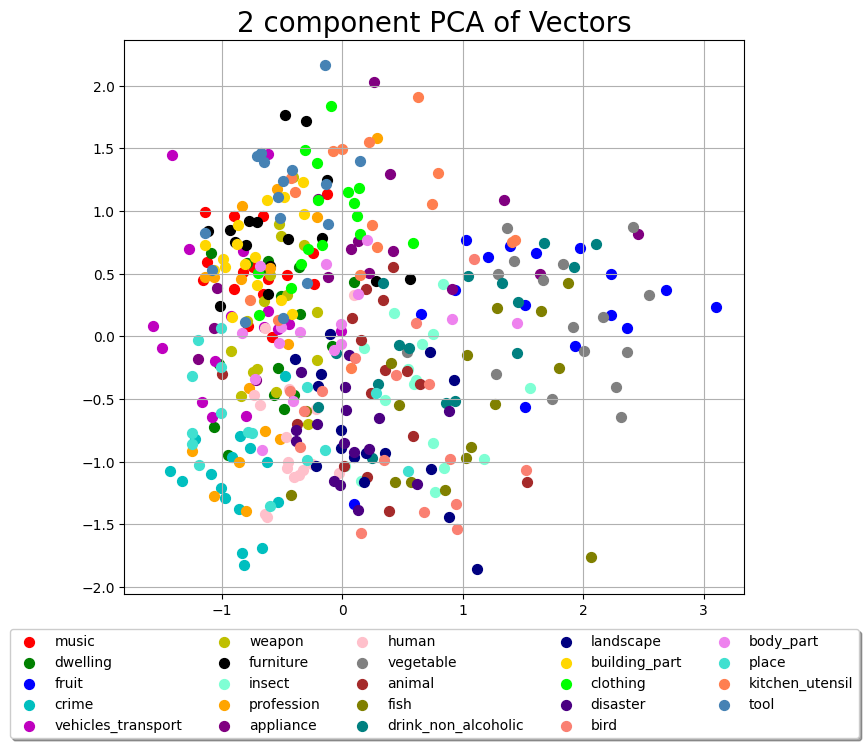

In [ ]:
ex2_df_vec = pd.DataFrame(data=ex2_vectors)
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(ex2_df_vec)

ex2_pca_vec = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
ex2_pca_vec['concept'] = concepts
ex2_pca_vec

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 component PCA of Vectors', fontsize = 20)
targets = concepts[0].unique()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'aquamarine','orange', 'purple', 'pink', 'gray', 'brown', 'olive', 'teal', 'navy', 'gold', 'lime', 'indigo', 'salmon', 'violet', 'turquoise', 'coral', 'steelblue']
for target, color in zip(targets,colors):
    indicesToKeep = ex2_pca_vec['concept'] == target
    ax.scatter(ex2_pca_vec.loc[indicesToKeep, 'principal component 1']
               , ex2_pca_vec.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(targets ,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.grid()
plt.show()

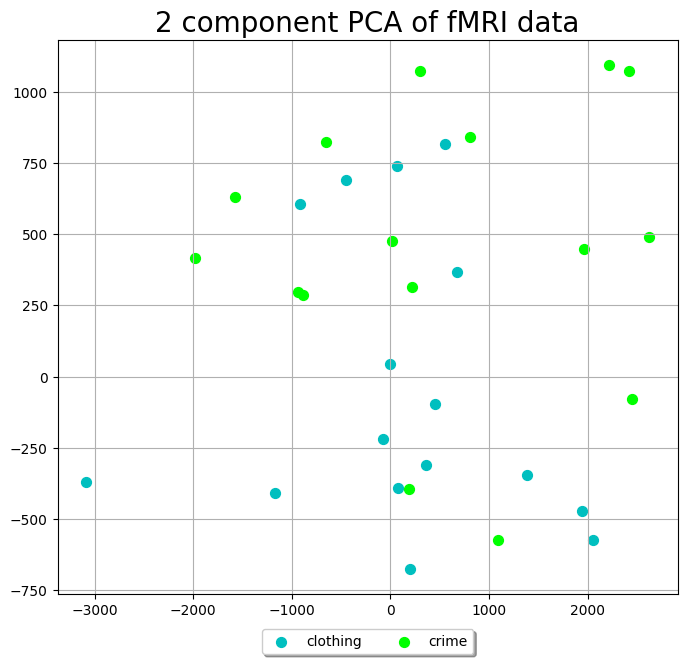

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 component PCA of fMRI data', fontsize = 20)
targets = ['clothing', 'crime']
colors = ['c','lime']
for target, color in zip(targets,colors):
    indicesToKeep = ex2_pca['concept'] == target
    ax.scatter(ex2_pca.loc[indicesToKeep, 'principal component 1']
               , ex2_pca.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(targets ,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.grid()
plt.show()

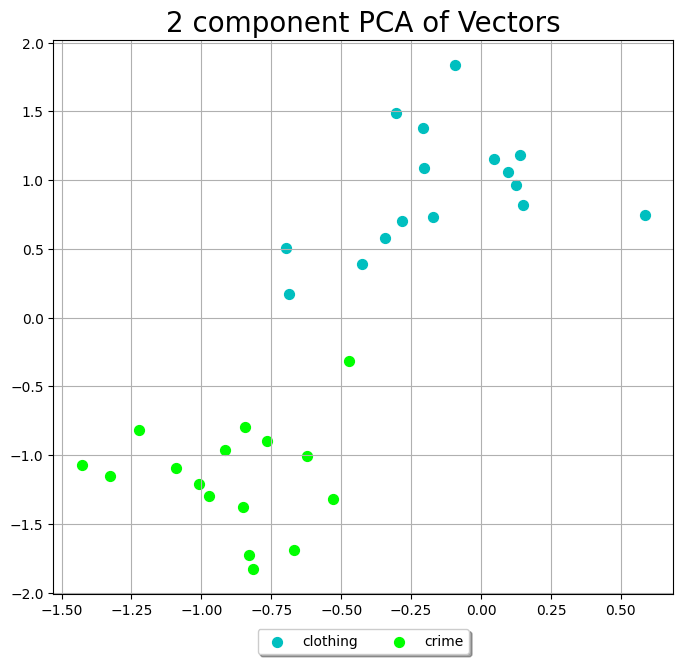

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 component PCA of Vectors', fontsize = 20)
targets = ['clothing', 'crime']
colors = ['c','lime']
for target, color in zip(targets,colors):
    indicesToKeep = ex2_pca_vec['concept'] == target
    ax.scatter(ex2_pca_vec.loc[indicesToKeep, 'principal component 1']
               , ex2_pca_vec.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(targets ,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.grid()
plt.show()

In [ ]:
ex3_data.shape

(243, 185866)

In [ ]:
ex3_df

0          1          2          3          4          5       \
0    -1.555565  -3.516779  -1.078744   3.365836  -9.146028 -12.881421   
1    -0.080154  -1.239231  -5.608680  -7.016136   2.273524  -0.493415   
2    -0.129418   3.900210  -0.088649  -5.559074 -10.502458  -5.405931   
3    -1.085519  -2.287041  -1.006100   3.782633  -4.640316  -7.378359   
4     8.256958   5.695861   3.344100   2.099111   6.274378   4.481069   
..         ...        ...        ...        ...        ...        ...   
238   4.483993   6.898242  10.713522  11.953808   7.029184   4.324179   
239  -0.485516   0.816571  -0.265004  -1.344047   2.729180   2.448014   
240  11.329010   4.560383   1.157311  -2.130414  15.595705   9.791190   
241  12.109047  11.874655   8.859670   3.624719   6.030235   9.194554   
242  11.595659   8.175237   6.107663   4.162524  12.855981   9.052953   

        6          7          8          9       ...     185856     185857  \
0   -13.085135 -12.048468  -9.395311  -4.331031  ...  -1.668775  -0.927825   
1    -1.544566  -3.907338  -4.627613  -3.750474  ...   3.654171   3.394179   
2    -3.793667  -7.543622 -10.126212  -9.896432  ...  -7.948170  -8.024925   
3    -8.882444 -10.787923  -6.716598  -6.035966  ...   2.444924   2.555662   
4     1.087190   0.200867   2.022621   3.317361  ...  -9.596880  -5.649739   
..         ...        ...        ...        ...  ...        ...        ...   
238   4.721288   8.702315  11.348930  11.945520  ... -20.889109 -40.361663   
239   1.413316  -0.503957  -1.310976   2.555545  ...  10.813463  -7.310754   
240   3.451545   1.584153   0.602408  -0.184266  ...  -6.355750  -9.988156   
241   7.994065   6.021345   4.599400   3.647232  ...  -1.192153  -2.218942   
242   6.198250   5.711226   5.806927   6.849541  ...   9.459043   6.974514   

        185858     185859     185860     185861     185862     185863  \
0   -12.534183 -15.057579  -5.186484 -13.669061   3.497427  -8.982974   
1     3.031683   9.009421   7.594709  15.939073  10.762124  16.216494   
2   -25.344870 -28.830719 -26.908063 -29.597280 -21.555530 -23.373113   
3     3.652418  -1.297796   6.711052  -5.373720   7.320068  -3.043977   
4    -8.676927 -14.650343 -14.302082 -17.825683 -14.892486 -17.713943   
..         ...        ...        ...        ...        ...        ...   
238 -52.478378 -57.556568 -47.519126 -45.273447 -42.332988 -36.288964   
239 -16.184386 -23.383047 -11.219656 -14.271191  -7.419907 -10.840584   
240  -5.914702   5.137141  -0.673854  15.422518   3.825852  16.996754   
241 -17.582473 -11.360995 -13.696239 -10.201047  -5.035296  -6.488725   
242   2.387168   7.189522   0.383344  13.043148   2.337273  14.476771   

        185864     185865  
0     3.425468  -4.840230  
1    10.589204  10.476710  
2   -16.513157 -17.551663  
3     2.671403  -0.473469  
4   -13.454286 -16.904129  
..         ...        ...  
238 -38.269352 -36.362934  
239  -9.147118 -15.059911  
240   3.151231   7.236146  
241  -0.458416  -2.163696  
242   4.476557   9.698329  

[243 rows x 185866 columns]

In [ ]:
ex3_df = pd.DataFrame(data=ex3_data)
pca = PCA(n_components=243)

principalComponents = pca.fit_transform(ex3_df)

ex3_pca_300 = pd.DataFrame(data = principalComponents, columns=[str(i) for i in range(243)])
ex3_pca_300

0            1            2           3           4  \
0    -192.740786    26.480996 -1195.957604 -243.360457   73.012770   
1    -703.323597  -121.955633   154.004400  192.321990  205.948055   
2    1743.820970    36.756579  -135.478280 -447.717939  -52.143116   
3    -882.545578   177.184998  -284.725510 -339.146100 -263.963567   
4    1072.979041   104.990240   328.464722  205.213617   76.938165   
..           ...          ...          ...         ...         ...   
238  2665.863551  -731.969000  -116.616412  -80.043342 -600.367151   
239   127.886320 -1276.141507  -347.040161 -147.488928 -325.536307   
240  1338.727252     6.689543   139.293874  621.730094  585.236994   
241   573.877567     1.195568  -383.413568 -348.617157 -464.855902   
242 -1363.419214   -14.600449  -354.503997 -139.808153 -572.120249   

              5           6           7           8           9  ...  \
0    370.801577  164.638837  202.963721 -111.643138  -32.317015  ...   
1   -322.405560   58.281841   80.772853 -238.464744 -320.907521  ...   
2    581.031410 -296.395865 -453.069913 -502.642117 -742.765266  ...   
3    365.779118  170.578397 -120.649859 -114.561005 -454.411222  ...   
4    234.809570  741.250168  116.233279   84.060662 -203.993219  ...   
..          ...         ...         ...         ...         ...  ...   
238 -530.747987 -870.200167 -569.027199   59.152667  243.702574  ...   
239 -180.961045 -976.445300 -777.036622   -5.156384  509.559236  ...   
240 -313.065741  291.147945 -271.718867  306.710872   13.723389  ...   
241   54.763155 -506.732749 -500.533064   17.512059 -333.774782  ...   
242 -299.802869 -139.632166    4.456532   22.067314 -198.310129  ...   

            233        234        235        236         237        238  \
0     33.538315   9.396185   7.009651  -2.286110   18.451546 -16.035845   
1    -38.884093  34.072524 -14.226415 -58.590835  -82.236793  29.267511   
2     14.646277  -4.043140   8.430671 -29.032272  100.449269  12.704854   
3     34.344414 -92.275005  65.425500  11.229944  -56.598039   3.467247   
4     24.180920  -5.985908  15.181008  58.759901   15.975017 -53.355362   
..          ...        ...        ...        ...         ...        ...   
238  -55.459371  10.408432  10.131371 -51.309196   13.234326 -23.639175   
239   41.889970 -61.380476 -41.210170  27.390969  -71.527002  -0.749923   
240   28.631757 -37.258123  11.946145 -32.482390  -46.490771 -37.222631   
241   32.789667  -8.107491 -46.906234  71.660171  -39.481173 -28.995879   
242 -126.640030  19.165389  26.108834 -13.583778  136.114875  -1.252330   

            239         240         241           242  
0     14.967520  -66.902687  -33.333818  4.774033e-13  
1     23.663793   46.074825   12.423771  4.774033e-13  
2    -17.604277  -18.871554   -7.556238  4.774033e-13  
3     -4.693246  -21.415476  -23.825517  4.774033e-13  
4    -22.566612   30.309422    2.542028  4.774033e-13  
..          ...         ...         ...           ...  
238  111.704835  137.763829 -111.343976  4.774033e-13  
239 -114.801811 -114.985982   38.921437  4.774033e-13  
240   33.299540  -39.933493  -75.929520  4.774033e-13  
241   16.190927  105.734216   58.504947  4.774033e-13  
242  -67.975912  -83.708176   92.374047  4.774033e-13  

[243 rows x 243 columns]

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=24, n_init="auto").fit(ex3_pca_300)
labels = kmeans.predict(ex3_pca_300)
centroids  = kmeans.cluster_centers_
kmeans.labels_

array([ 2, 13,  8, 19,  7,  8, 10, 14, 21,  7,  8, 19, 19, 19, 19, 16,  3,
        8,  2, 11, 11, 16, 20, 11, 10,  2,  2, 11,  3, 11, 14, 10, 21, 11,
       19, 23,  2,  8, 10,  2, 10,  2, 10, 20, 14,  2, 21, 11, 10,  2, 13,
        9, 18,  9, 19, 23,  2, 10, 13, 13, 14, 15, 19, 19, 11,  9,  3,  8,
       18, 16, 21,  2, 16, 11, 19, 16,  8,  5, 15,  8, 19,  7, 11, 10, 14,
       16, 11, 16,  3,  5,  8, 10,  8, 17,  2, 16, 16,  8, 20,  1,  5, 14,
        2, 20, 19, 17, 17, 22, 10, 19,  2, 21, 12, 18,  1,  3, 10, 10, 12,
       20, 20,  2, 21,  4, 19, 20,  5,  8, 10, 10, 11, 16, 10, 13,  3,  0,
       11, 10,  5, 18,  9,  3,  7,  2,  2,  8, 13, 13,  2,  7,  4, 16, 14,
       11, 11, 21, 21,  1, 21, 13,  2, 18,  2, 19, 19,  7, 19, 19, 16, 20,
       23, 19, 20, 17, 18, 10, 12, 12,  7, 20,  8, 20, 15, 15, 15, 15, 21,
        2,  2,  7,  2,  7,  4,  6,  6,  6, 12, 11, 19, 10, 21, 11,  2,  2,
        8, 10,  8, 13, 11,  7, 21,  8, 15, 14, 15, 15,  7,  8, 14, 14, 21,
       11,  1,  1, 19, 16

In [ ]:
ex3_pca_300['concept'] = concepts
ex3_pca_300['kmeans'] = kmeans.labels_

In [ ]:
concepts[0].unique()

array(['beekeeping', 'dreams', 'gambling', 'hurricane', 'ice_cream',
       'lawn_mower', 'astronaut', 'computer_graphics', 'law_school',
       'pharmacist', 'stress', 'tuxedo', 'blindness', 'taste',
       'bone_fracture', 'infection', 'opera', 'painter', 'owl',
       'polar_bear', 'castle', 'pyramid', 'rock_climbing', 'skiing'],
      dtype=object)

In [ ]:
ex3_pca_300[ex3_pca_300['concept'] == 'opera']['kmeans']

161    18
162     2
163    19
164    19
165     7
166    19
167    19
168    16
169    20
170    23
171    19
Name: kmeans, dtype: int32

# Unsupervised method

In [ ]:
def get_sentence_categories(exp):
  sentence_category = []
  passage_sentence = exp['labelsPassageForEachSentence']
  passage_category_index = exp['labelsPassageCategory']
  category_index = exp['keyPassageCategory'][0]
  for i in range(len(passage_sentence)):
    sentence_category.append(category_index[passage_category_index[passage_sentence[i][0] - 1][0]  - 1][0])
  return sentence_category


In [ ]:
ex2_concepts = get_sentence_categories(exp2)

In [ ]:
from tqdm import tqdm

def get_exp_sentences(exp):
  sentences_exp = exp['keySentences']
  sentences = []
  for i in tqdm(range(len(sentences_exp))):
    sentences.append(sentences_exp[i][0][0])
  print(len(sentences))
  return sentences

In [ ]:
ex2_sentencess = get_exp_sentences(exp2)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_centroids(data, labels, num_clusters):
    centroids = np.zeros((num_clusters, data.shape[1]))  # Initialize centroid array
    similerity_list = []
    for cluster in range(num_clusters):
        cluster_points = data[labels == cluster]  # Get data points belonging to the current cluster
        cluster_centroid = np.mean(cluster_points, axis=0)  # Calculate mean across the data points

        # Calculate cosine similarity between cluster points and centroid
        similarities = cosine_similarity(cluster_points, [cluster_centroid])

        # Compute average cosine similarity within the cluster
        average_similarity = np.mean(similarities)
        similerity_list.append(average_similarity)
        print(f"Cluster {cluster+1}: Average similarity = {average_similarity}")

        centroids[cluster] = cluster_centroid  # Assign the centroid to the cluster centroid array
    print(np.mean(similerity_list))
    return centroids

In [ ]:
ex2_df_full = pd.DataFrame(data=ex2_data)

In [ ]:
from sklearn.cluster import KMeans
random_seed = 42  # Set a specific random seed

kmeans = KMeans(n_clusters=14, n_init="auto", random_state=random_seed).fit(ex2_df_full)
labels = kmeans.predict(ex2_df_full)
centroids  = kmeans.cluster_centers_
kmeans.labels

In [ ]:
centroids = calculate_centroids(ex2_df_full, kmeans.labels_, 14)


In [ ]:
ex2_df_full['sentence'] = ex2_sentencess
ex2_df_full['kmeans'] = kmeans.labels_
ex2_df_full['concepts'] = ex2_concepts

In [ ]:
i =0
for index, row in ex2_df_full[ex2_df_full['kmeans'] == 0].iterrows():

    # Access column values using column names
    print("sentence:", row['sentence'])
    print("Concepts:", row['concepts'])
    print("---")
    i+=1
print(i)

In [ ]:
from scipy import stats
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def redisual_analysis(X, y, y_hat, print_table = False):
    # Calculates residuals analysis and prints the table if requested
    n = X.shape[0]
    p = X.shape[1]

    y_bar = np.mean(y)
    SSR = np.linalg.norm(y_hat - y_bar) ** 2
    SSRes = np.linalg.norm(y - y_hat) ** 2
    SST = SSR + SSRes

    MSR = SSR / (p - 1)
    MSRes = SSRes / (n - p)
    MST = SST / (n - 1)

    f_test = MSR / MSRes
    f_p_value = 1 - stats.f.cdf(f_test, p -1, n- p)

    if print_table:
        residual_values = [(SSR, p - 1, MSR, f_test, f_p_value),
                           (SSRes, n - p, MSRes, None, None),
                           (SST, n - 1, MST, None, None)]
        residual_table = pd.DataFrame(residual_values, columns=['Sum Of Squares', 'df', 'MS', 'F Value', 'F P-Value'],
                                      index=['Regression', 'Residuals', 'Total'])
        print(residual_table)

    return SSR, SSRes, SST, MSR, MSRes, MST, f_test, f_p_value

def calc_R_2(SSR, SST):
    return SSR / SST


def get_inv_XT_X(X):
    XT_X = np.matmul(X.T, X)
    return np.linalg.inv(XT_X)

In [ ]:
voxel_number = list(range(ex2_data.shape[1]))
voxel_list = []

X = ex2_vectors
bias_column = np.ones((X.shape[0], 1))
X = np.hstack((bias_column, X))
inv_XT_X = get_inv_XT_X(X)
P = np.matmul(inv_XT_X, X.T)

for voxel in tqdm(voxel_number):
  y = ex2_data[:, voxel]
  beta_LS = np.matmul(P, y)
  y_hat = np.matmul(X, beta_LS)
  SSR, SSRes, SST, MSR, MSRes, MST, f_test, f_p_value = redisual_analysis(X, y, y_hat)
  R2 = calc_R_2(SSR, SST)
  voxel_list.append((voxel, R2, f_p_value))

In [ ]:
voxel_list.sort(key=lambda a: a[2])
s = 5000
top_segnificant = [voxel_list[i][0] for i in range(s)]
segnificant_voxels = ex2_data[:, top_segnificant]

In [ ]:
ex2_df = pd.DataFrame(data=segnificant_voxels)
pca = PCA(n_components=200)

principalComponents = pca.fit_transform(ex2_df)

ex2_pca_200 = pd.DataFrame(data = principalComponents, columns=[str(i) for i in range(200)])
ex2_pca_200

In [ ]:
from sklearn.cluster import KMeans
random_seed = 42  # Set a specific random seed

kmeans = KMeans(n_clusters=14, n_init="auto", random_state=random_seed).fit(ex2_pca_200)
labels = kmeans.predict(ex2_pca_200)
centroids  = kmeans.cluster_centers_
kmeans.labels_

In [ ]:
centroids = calculate_centroids(ex2_pca_200, kmeans.labels_, 14)


In [ ]:
ex2_pca_200['sentence'] = ex2_sentencess
ex2_pca_200['kmeans'] = kmeans.labels_
ex2_pca_200['concepts'] = ex2_concepts

In [ ]:
i =0
for index, row in ex2_pca_200[ex2_pca_200['kmeans'] == 5].iterrows():

    # Access column values using column names
    print("sentence:", row['sentence'])
    print("Concepts:", row['concepts'])
    print("---")
    i+=1
print(i)

In [ ]:
ex2_sentencess

K-means for the embadding

In [ ]:
ex2_df_embedding = pd.DataFrame(data=ex2_vectors)


In [ ]:
kmeans = KMeans(n_clusters=15, n_init="auto").fit(ex2_df_embedding)
labels = kmeans.predict(ex2_df_embedding)
centroids  = kmeans.cluster_centers_
kmeans.labels_

In [ ]:
centroids = calculate_centroids(ex2_df_embedding, kmeans.labels_, 15)


In [ ]:
ex2_df_embedding['sentence'] = ex2_sentencess
ex2_df_embedding['kmeans'] = kmeans.labels_
ex2_df_embedding['concepts'] = ex2_concepts

In [ ]:
for index, row in ex2_df_embedding[ex2_df_embedding['kmeans'] ==7].iterrows():
    # Access column values using column names
    print("sentence:", row['sentence'])
    print("concepts:", row['concepts'])

    print("---")